# Cross-Sell-Prediction
Here, I am going to try and run various classifiers I learnt in class. They are mostly simple and fundamental models, yet there are many more advanced classifiers available (You may try on your own or take a look of my another notebook *How-Many-Customer-Stay* where I have used more advanced models such as gradient boosting)

## Import data

In [132]:
import pandas as pd
import numpy as np

In [133]:
df_train = pd.read_csv('insurance-train.csv', index_col=0)
df_test = pd.read_csv('insurance-test.csv', index_col=0)
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Female,28,1,11.0,1,< 1 Year,No,29694.0,152.0,153,0
1,Female,42,1,33.0,1,1-2 Year,No,42606.0,124.0,278,0
2,Female,50,1,29.0,0,> 2 Years,Yes,33020.0,155.0,288,0
3,Male,24,1,41.0,1,< 1 Year,No,48894.0,152.0,126,0
4,Female,44,1,48.0,0,1-2 Year,Yes,2630.0,26.0,154,0


## Explanatory Data Analysis
Now we take a closer look at the insurance data and what preprocessing we should employ. 

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [135]:
df_train.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,342999.000000,342999.000000,342999.000000,342999.000000,342999.000000,342999.000000,342999.000000,342999.000000
mean,38.829489,0.997915,26.393185,0.458100,30558.360771,112.006140,154.367887,0.122808
std,15.511843,0.045609,13.229196,0.498242,17238.711480,54.217773,83.666962,0.328217
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24397.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31657.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39398.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


We can see that the mean of the `Response` column is very low. If the data was balanced, the mean should be 0.5

In [136]:
df_train['Response'].value_counts(normalize=True)

0    0.877192
1    0.122808
Name: Response, dtype: float64

Further inspection shows that the values in the `Response` column is indeed very imbalanced. One of the methods to solve such problem is resampling, so we will upsample/downsample our training set later on. 

In [137]:
df_train.describe(include='O')

,Gender,Vehicle_Age,Vehicle_Damage
count,342999,342999,342999
unique,2,3,2
top,Male,1-2 Year,Yes
freq,185609,180268,173167


There are two, three, two unique values for Gender, Vehicle_Age, Vehicle_Damage respectively

#### Check for missing value

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342999 entries, 0 to 342998
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                342999 non-null  object 
 1   Age                   342999 non-null  int64  
 2   Driving_License       342999 non-null  int64  
 3   Region_Code           342999 non-null  float64
 4   Previously_Insured    342999 non-null  int64  
 5   Vehicle_Age           342999 non-null  object 
 6   Vehicle_Damage        342999 non-null  object 
 7   Annual_Premium        342999 non-null  float64
 8   Policy_Sales_Channel  342999 non-null  float64
 9   Vintage               342999 non-null  int64  
 10  Response              342999 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 31.4+ MB


No missing values for all columns

#### Correlation analysis (for numeric and binary attributes)

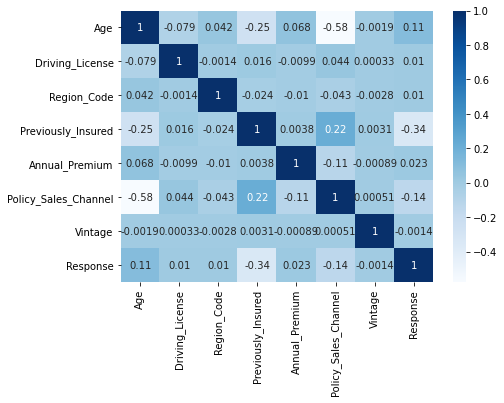

In [139]:
plt.figure(figsize=(7,5))
cor=df_train[df_train.describe().columns].corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

By looking at this heat map we can see that `Response` has the highest correlation with features `Previously_Insured` (If people already have transport insurance, the less likely they would buy the insurance, make sense!), we can predict `Previously_Insured` will be an important feature

In [140]:
df_train.groupby('Vehicle_Age')['Response'].value_counts(normalize=True)

Vehicle_Age  Response
1-2 Year     0           0.825965
             1           0.174035
< 1 Year     0           0.956299
             1           0.043701
> 2 Years    0           0.704519
             1           0.295481
Name: Response, dtype: float64

We can see that people with an older car tend to buy the insurance 

In [141]:
df_train.groupby('Vehicle_Damage')['Response'].value_counts(normalize=True)

Vehicle_Damage  Response
No              0           0.994754
                1           0.005246
Yes             0           0.761895
                1           0.238105
Name: Response, dtype: float64

We can see that people with a damaged car tend to buy the insurance

In [142]:
df_train['Annual_Premium'].describe()

count    342999.000000
mean      30558.360771
std       17238.711480
min        2630.000000
25%       24397.000000
50%       31657.000000
75%       39398.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

There are some extremly large values. Let's plot a boxplot to have a deeper look.

<AxesSubplot:>

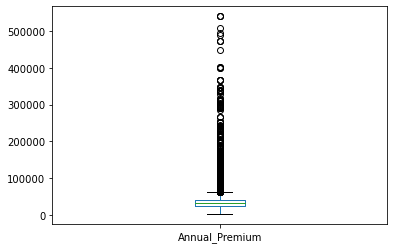

In [143]:
df_train['Annual_Premium'].plot(kind="box")

There are indeed some outliers. We need to remove them in the next step.

## Data Preprocessing

We start by transforming categorial data `Gender`,`Vehicle_Age`,`Vehicle_Damage` into numerical data

In [144]:
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
le = LabelEncoder()
df_train['Gender'] = le.fit_transform(df_train['Gender'])
df_test['Gender'] = le.transform(df_test['Gender'])
df_train['Vehicle_Damage'] = le.fit_transform(df_train['Vehicle_Damage'])
df_test['Vehicle_Damage'] = le.transform(df_test['Vehicle_Damage'])

# since Vehicle_Age is ordinal, we encode explicitly
df_train['Vehicle_Age'] = df_train['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
df_test['Vehicle_Age'] = df_test['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

We then smooth the data by removing outliers and binning the `Annual_Premium` column

In [145]:
# removing outliers
Q1 = 24397.000000
Q3 = 39398.000000
IQR = Q3-Q1
df_train = df_train[(df_train['Annual_Premium']>Q1-1.5*IQR) & (df_train['Annual_Premium']<Q3+1.5*IQR)]

# binning 
discretizer = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
df_train['Annual_Premium']=discretizer.fit_transform(df_train['Annual_Premium'].values.reshape(-1, 1)).astype(int)
df_test['Annual_Premium']=discretizer.transform(df_test['Annual_Premium'].values.reshape(-1, 1)).astype(int)

In [146]:
df_train.drop_duplicates(inplace = True)

Next we perform feature selection to select the highest scoring features in this dataset. Say we pick k = 7. To find the best value of K, you can fit multiple models with different K, then choose the one with highest validation score.

In [147]:
y = df_train['Response']
X = df_train.drop('Response', axis=1)

In [148]:
from sklearn.feature_selection import SelectKBest
skb = SelectKBest(k=7)
skb.fit_transform(X, y)
X.columns[~skb.get_support()]

Index(['Driving_License', 'Region_Code', 'Vintage'], dtype='object')

If we choose 7 features only, we can see that the algorithm suggests that `Driving License, Region_Code, Vintage` are the features with the lowest scores. This corresponds with the earlier result we got from the correlation heatmap. So we remove them from our training and testing data. 

In [149]:
X.drop(columns=['Driving_License', 'Region_Code', 'Vintage'], inplace=True)
df_test.drop(columns=['Driving_License', 'Region_Code', 'Vintage'], inplace=True)

We then split the train data with test size of 0.2

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Note that the X_test and y_test is also actually called the validation set. Since we have df_test as the testing set.

After splitting, we perform random oversampling on the dataset to increase the number of '1's. Oversampling generally yields a better performance. But for SVC, we will instead apply a downsampled dataset due to the long training time.

In [151]:
from sklearn.utils import resample
reX = pd.concat([X_train, y_train], axis=1)
no_response = reX[reX['Response'] == 0]
has_response = reX[reX['Response'] == 1]
has_response = resample(has_response,replace = True, n_samples=int(len(no_response)*2/3), random_state=8)                   
resample_df = pd.concat([no_response,has_response])
y_train_up = resample_df['Response']
X_train_up = resample_df.drop('Response', axis=1)

print('oversampled data:', Counter(y_train_up).items())

oversampled data: dict_items([(0, 233485), (1, 155656)])


In [152]:
reX = pd.concat([X_train, y_train], axis=1)
no_response = reX[reX['Response'] == 0]
has_response = reX[reX['Response'] == 1]
no_response = resample(no_response,replace = True, n_samples=len(has_response), random_state=8)                   
resample_df = pd.concat([no_response,has_response])
y_train_down = resample_df['Response']
X_train_down = resample_df.drop('Response', axis=1)

print('undersampled data:', Counter(y_train_down).items())

undersampled data: dict_items([(0, 32613), (1, 32613)])


## Hyperparameter Tuning and Model Training

Here, we will try and compare different models: Decision Tree, KNN, Navie Bayes, Support Vector Machine, Randome Forest, Bagging, Adaboost\
We will also tune some parameters:\
SVM: C\
KNN: k\
Decision Tree: max depth\
Ensemble: the number of classifier\
Naive Bayes: use the model with laplace or not

In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

### Decision Tree

In [154]:
trainAcc_dtree = []
testAcc_dtree = []
f1_dtree = []

In [155]:
max_depth = [1, 5, 10, 15, 20, 25, 30, 35]

for d in max_depth:    
    dt = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=8)
    dt = dt.fit(X_train_up, y_train_up)
    Y_predTrain = dt.predict(X_train_up)
    Y_predTest = dt.predict(X_test)
    trainAcc_dtree.append(accuracy_score(y_train_up, Y_predTrain))
    testAcc_dtree.append(accuracy_score(y_test, Y_predTest))
    f1_dtree.append(f1_score(y_test, Y_predTest))

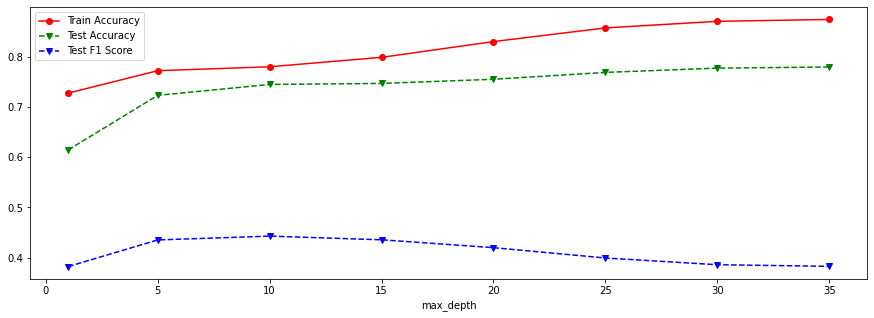

In [156]:
plt.figure(figsize = (15,5))
plt.plot(max_depth,trainAcc_dtree,'ro-', max_depth,testAcc_dtree,'gv--', max_depth,f1_dtree,'bv--')
plt.legend(['Train Accuracy','Test Accuracy','Test F1 Score'])
plt.xlabel('max_depth')
plt.show()

From the graph, we can see that we should choose the model when max_depth is 5 or 10, we will have a deeper look in the next step.\
Another intersting thing to point out is that when max_depth > 20, overfitting problem occur, as the gap between training accuracy and testing accuracy is becoming larger and training accuracy is around 90%, very high!

In [157]:
print(f1_dtree)

[0.3820501073038991, 0.4351351351351351, 0.44269086604853025, 0.435392881128274, 0.41969669937555754, 0.39909190543291057, 0.38567035159172136, 0.3824795341379019]


#### Results: 
The maximum f1 score we can get from the decision tree is 0.443 at max_depth = 10.


| max_depth | 1 | 5 | 10 | 15 | 20 | 25 | 30 | 35 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| **f1 score** | 0.382 | 0.435 | **0.443** | 0.435 | 0.420 | 0.399 | 0.386 | 0.382 |

### K-Nearest Neighbors

In [158]:
f1_knn = []
num_neighbors = [5, 10, 15, 20, 25, 30]

for k in num_neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, weights='distance', metric='minkowski', p=2, n_jobs=-1)
    knn.fit(X_train_up, y_train_up)
    Y_predTest = knn.predict(X_test)
    f1_knn.append(f1_score(y_test, Y_predTest))

In [159]:
print('f1 Score:', f1_knn)

f1 Score: [0.35857497928748966, 0.3639592406240751, 0.37524872225039996, 0.37838050934321527, 0.3815587603559374, 0.3810628916221861]


#### Results: 
The maximum f1 score we can get from knn is 0.382 at k = 25. 

| neighbors | 5 | 10 | 15 | 20 | 25 | 30 |
| --- | --- | --- | --- | --- | --- | --- | 
| **f1 score** | 0.359 | 0.364 | 0.375 | 0.378 | **0.382** | 0.381 |

### Naive Bayes

In [160]:
f1_nb = []
gnb = GaussianNB() # with no laplace smoothing
mnb = MultinomialNB(alpha=1) # with laplace smoothing
nb_classifiers = [gnb, mnb]

for nb in nb_classifiers:
    nb.fit(X_train_up, y_train_up)
    Y_predTest = nb.predict(X_test)
    f1_nb.append(f1_score(y_test, Y_predTest))

In [161]:
print('f1 Score:', f1_nb)

f1 Score: [0.398166339227243, 0.2757609333246432]


#### Results: 
We tested 2 types of Naive Bayes Classifier, and Gaussian yields better result at an f1 score of 0.398.

| Classifiers | GaussianNB | MultinominalNB |
| --- | --- | --- | 
| **f1 score** | **0.398** | 0.276 |

### SVM
For SVM, due to limited computational resources, it requires excessive running time (say a few days) to finish the training phase. To alleviate such an issue, I used downsampled training set so that the training process can finish in a reasonable time (say a few hours).

In [162]:
f1_svm = []
c_values = [0.1, 1, 10, 100]

for c in c_values:
    svc = SVC(kernel='rbf', C=c)
    svc.fit(X_train_down,y_train_down)
    Y_predTest = svc.predict(X_test)
    f1_svm.append(f1_score(y_test, Y_predTest))

In [163]:
print('f1 Score:', f1_svm)

f1 Score: [0.3005592893735019, 0.40677013045434096, 0.40551716917922953, 0.4033708152967393]


#### Results
The rbf kernal generated the best result of 0.407 when `C=1`.

| C Value | 0.1 | 1 | 10 | 100 |
| --- | --- | --- | --- | --- |
| **f1 score** | 0.301 | **0.407** | 0.406 | 0.403 |

### Ensemble: Random Forest

In [164]:
maxdepth = 5 # or any other value, you can also try optimize this parameter
numBaseClassifiers = [10,100,500]

In [165]:
f1_rf = []

for n in numBaseClassifiers:   
    rf = RandomForestClassifier(n_estimators=n,max_depth=maxdepth,
                                n_jobs=-1,class_weight="balanced", random_state=8)
    rf.fit(X_train_up, y_train_up)
    Y_predTest = rf.predict(X_test)
    f1_rf.append(f1_score(y_test, Y_predTest))

In [166]:
print('f1 Score:', f1_rf)

f1 Score: [0.4199518632251639, 0.42121068876345136, 0.42222719391464847]


#### Results: 
The improvement in f1 score is not significant. We will take the result of 0.422 for random forest.

### Ensemble: Bagging

In [167]:
f1_bag = []
dtc = DecisionTreeClassifier(criterion="gini", max_depth=maxdepth, random_state=8)

for n in numBaseClassifiers:   
    bag = BaggingClassifier(dtc, n_estimators=n,n_jobs=-1, random_state=1)
    bag.fit(X_train_up, y_train_up)
    Y_predTest = bag.predict(X_test)
    f1_bag.append(f1_score(y_test, Y_predTest))

In [168]:
print('f1 Score:', f1_bag)

f1 Score: [0.43699740292249445, 0.43706578206171365, 0.43707946045754703]


#### Results: 
The f1 scores are almost the same at 0.437 for all the tested n_estimators

### Ensemble: Adaboost

In [169]:
f1_ada = []
for n in numBaseClassifiers:   
    ada = AdaBoostClassifier(dtc, n_estimators=n, random_state=1)
    ada.fit(X_train_up, y_train_up)
    Y_predTest = ada.predict(X_test)
    f1_ada.append(f1_score(y_test, Y_predTest))

In [170]:
print('f1 Score:', f1_ada)

f1 Score: [0.44416375178131884, 0.4402540690750298, 0.431523642732049]


#### Results: 
Adaboost gives the best result of 0.444 when n_estimators = 10

## Conclusion

Collecting the highest scores from each classifier, we get the table: 

| Classifier | Hyperparameter | f1 score |
| --- | --- | --- | 
| Decision Tree | `max_depth=10` | **0.443** |
| k-Nearest Neighbors | `n_neighbors=25` | 0.382 | 
| Naive Bayes | `GaussianNB()` | 0.398 |
| SVM | `kernal='rbf',C=1` | 0.407 | 
| Random Forest | `n_estimators=500, max_depth=5` | 0.422 |
| Bagging | `base_estimator=DecisionTreeClassifier(), n_estimators=500, max_depth=5` | 0.437 | 
| Adaboost | `base_estimator=DecisionTreeClassifier(), n_estimators=10, max_depth=5` | **0.444** |


From which we can conclude that with our preprocessing methods, the 2 best classifiers are Decision Tree and Adaboost. 

In [171]:
# decision tree
dt = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=8)
dt = dt.fit(X_train_up, y_train_up)
dt_predictions = dt.predict(df_test)

df_submission = pd.read_csv('samplesubmission.csv')
df_submission['Response'] = dt_predictions
df_submission.to_csv('submission_1_dtree.csv', index = False)

In [172]:
# adaboost
ada = AdaBoostClassifier(dtc, n_estimators=10, random_state=1)
ada.fit(X_train_up, y_train_up)
ada_predictions = ada.predict(df_test)

df_submission = pd.read_csv('samplesubmission.csv')
df_submission['Response'] = ada_predictions
df_submission.to_csv('submission_1_ada.csv', index = False)

Using these classifiers to predict `insurance-test.csv`, we get the results:

| Classifier | Hyperparameter | f1 score |
| --- | --- | --- | 
| Decision Tree | `max_depth=10` | **0.4375** |
| Adaboost | `base_estimator=DecisionTreeClassifier(), n_estimators=10, max_depth=15` | **0.4383** |

Indeed, Adaboost still slightly outperforms Decision Tree